In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully!")
print(" PyTorch version:", torch.__version__)



 All libraries imported successfully!
 PyTorch version: 2.7.1+cu126


In [20]:
sample_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming the world in amazing ways.",
    "Once upon a time, there was a magical kingdom filled with wonder.",
    "Python is a powerful programming language for data science and AI.",
    "The future holds incredible possibilities for technology and humanity.",
    "Machine learning algorithms can learn patterns from data automatically.",
    "In a galaxy far far away, adventures await brave explorers.",
    "Deep learning networks process information in layers like the human brain.",
    "Creativity and innovation drive progress in science and technology.",
    "The ocean waves crash against the shore under the moonlit sky."
]

# Combine all texts
full_text = " ".join(sample_texts).lower()
print(" Training data prepared!")
print(f" Total characters: {len(full_text)}")



 Training data prepared!
 Total characters: 653


In [21]:
chars = sorted(list(set(full_text)))
vocab_size = len(chars)

char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f" Vocabulary created!")
print(f" Vocabulary size: {vocab_size}")
print(f" Characters: {''.join(chars[:20])}..." if len(chars) > 20 else f"🔤 Characters: {''.join(chars)}")


 Vocabulary created!
 Vocabulary size: 29
 Characters:  ,.abcdefghijklmnopq...


In [22]:
def create_sequences(text, seq_length=10):
    sequences = []
    targets = []

    for i in range(len(text) - seq_length):
        seq = text[i:i + seq_length]
        target = text[i + seq_length]

        seq_indices = [char_to_idx[ch] for ch in seq]
        target_idx = char_to_idx[target]

        sequences.append(seq_indices)
        targets.append(target_idx)

    return torch.tensor(sequences), torch.tensor(targets)

sequence_length = 10
X, y = create_sequences(full_text, sequence_length)

print(f" Training sequences created!")
print(f" Number of sequences: {len(X)}")
print(f" Sequence length: {sequence_length}")


 Training sequences created!
 Number of sequences: 643
 Sequence length: 10


In [23]:
class SimpleTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim=50, hidden_dim=128, num_layers=2):
        super(SimpleTextGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)

        lstm_out, hidden = self.lstm(embedded, hidden)

        lstm_out = self.dropout(lstm_out[:, -1, :])

        output = self.fc(lstm_out)
        return output, hidden

model = SimpleTextGenerator(vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(" Model created successfully!")
print(f" Model parameters: {sum(p.numel() for p in model.parameters())}")



 Model created successfully!
 Model parameters: 229447


 Starting training...
Epoch 10/50, Loss: 1.6522
Epoch 20/50, Loss: 0.9634
Epoch 30/50, Loss: 0.7546
Epoch 40/50, Loss: 0.7810
Epoch 50/50, Loss: 0.7011
 Training completed!


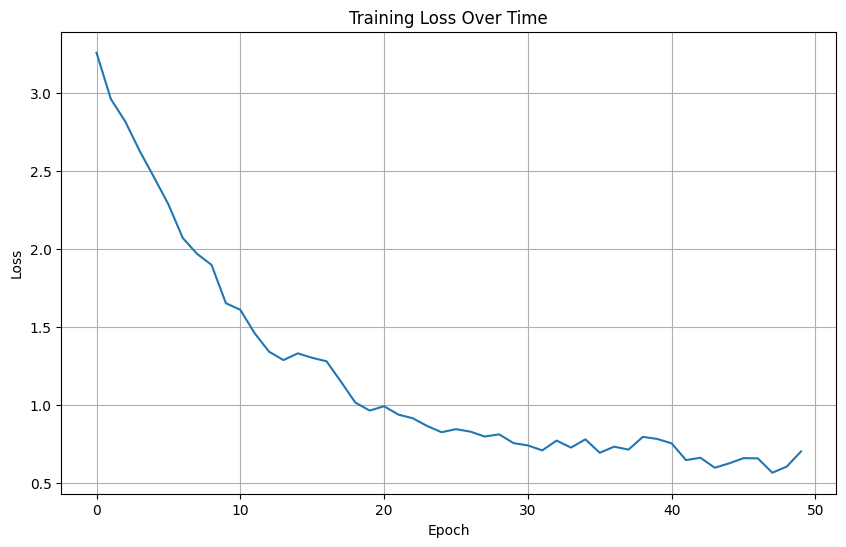

In [24]:
def train_model(model, X, y, epochs=50, batch_size=32):
    model.train()
    losses = []

    print(" Starting training...")

    for epoch in range(epochs):
        total_loss = 0

        # Shuffle data
        indices = torch.randperm(len(X))

        for i in range(0, len(X), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]

            # Forward pass
            optimizer.zero_grad()
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (len(X) // batch_size)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    print(" Training completed!")
    return losses

# Train the model
training_losses = train_model(model, X, y, epochs=50)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(training_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()



In [25]:
def generate_text(model, seed_text, length=100, temperature=1.0):
    model.eval()

    if len(seed_text) < sequence_length:
        seed_text = seed_text + " " * (sequence_length - len(seed_text))

    seed_text = seed_text.lower()
    generated = seed_text

    current_seq = [char_to_idx.get(ch, 0) for ch in seed_text[-sequence_length:]]

    with torch.no_grad():
        for _ in range(length):
            x = torch.tensor([current_seq]).long()

            output, _ = model(x)

            output = output / temperature
            probabilities = torch.softmax(output, dim=1)

            next_char_idx = torch.multinomial(probabilities, 1).item()
            next_char = idx_to_char[next_char_idx]

            generated += next_char

            current_seq = current_seq[1:] + [next_char_idx]

    return generated

print(" Text generation function ready!")



 Text generation function ready!


In [30]:
def interactive_generator():
    print("\n" + "-"*50)
    print("INTERACTIVE TEXT GENERATOR")
    print("-"*50)
    print("Enter your prompts and watch the AI continue!")
    print("Type 'quit' to exit\n")

    while True:
        user_prompt = input("Enter your prompt: ").strip()

        if user_prompt.lower() in ['quit', 'exit', 'q']:
            print(" Thanks for using the generator!")
            break

        if not user_prompt:
            print("Please enter a valid prompt!")
            continue

        try:
            length = int(input("Length (default 60): ") or 60)
            temp = float(input("Temperature 0.1-2.0 (default 1.0): ") or 1.0)
        except ValueError:
            length, temp = 60, 1.0

        print(f"\n Generating text...")
        result = generate_text(model, user_prompt, length=length, temperature=temp)
        print(f"Result: {result}")
        print("-" * 40)



In [29]:

print("\n" + "-"*50)
print(" MODEL STATISTICS")
print("-"*50)

print(f" Vocabulary size: {vocab_size}")
print(f" Training sequences: {len(X)}")
print(f" Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f" Final training loss: {training_losses[-1]:.4f}")




--------------------------------------------------
 MODEL STATISTICS
--------------------------------------------------
 Vocabulary size: 29
 Training sequences: 643
 Model parameters: 229,447
 Final training loss: 0.7011
